In [1]:
import os, sys, glob, pdb, random, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from PIL import Image
from importlib import reload
from skimage import measure

sys.path.append('../')
import models.BuildCNN as BuildCNN
import models.LeafTracer as LeafTracer
import utils.TraceInitializer as TraceInitializer
from utils.GetLowestGPU import GetLowestGPU

if 'device' not in locals():
    device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 02915MiB / 40537MiB
  1  | 06238MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 02694MiB / 40537MiB
---------------------------
 Device set to cuda:2
---------------------------


# Initialize tracer

In [2]:
# options
window_size = 256
path_length = 128
step_length = 32
close_dist = 10
weights_path = f'../weights/leaf_tracer_{window_size}_best_val_model.save'
layers = [4, 32, 32, 32, 32, 32, 64, 128]
output_shape = [2, path_length]
output_activation = None

# load CNN model
print('loading cnn model...')
reload(BuildCNN)
model = BuildCNN.CNN(
    window_size=window_size, 
    layers=layers,
    output_shape=output_shape,
    output_activation=output_activation).to(device)
weights = torch.load(weights_path, map_location=device)
model.load_state_dict(weights)
model.eval()

# leaf tracer
print('initializing tracer...')
reload(LeafTracer)
tracer = LeafTracer.LeafTracer(
    model=model,
    window_size=window_size, 
    path_length=path_length, 
    step_length=step_length, 
    close_dist=close_dist, 
    device=device, 
    verbose=False)

# trace initializer
print('initializing trace...')
reload(TraceInitializer)
TI = TraceInitializer.TraceInitializer(
    window_size=window_size, 
    step_length=64, 
    device=device)

loading cnn model...
initializing tracer...
initializing trace...


# Tracer inference

Loading C_1_10_10_bot.jpeg...
Initializing trace...
Iteration completed in 1.15 seconds
Plotting overlay...


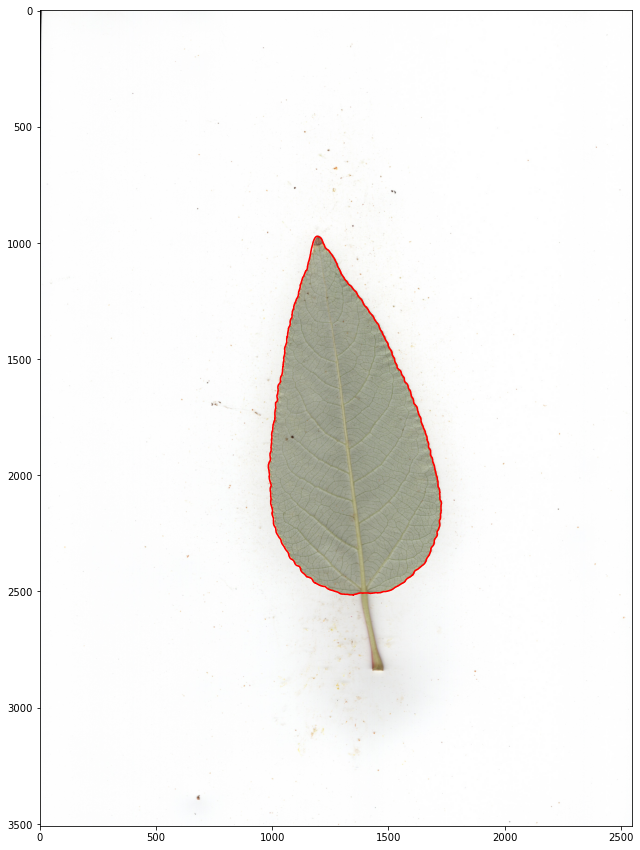


Loading C_1_10_10_top.jpeg...
Initializing trace...
Iteration completed in 1.05 seconds
Plotting overlay...


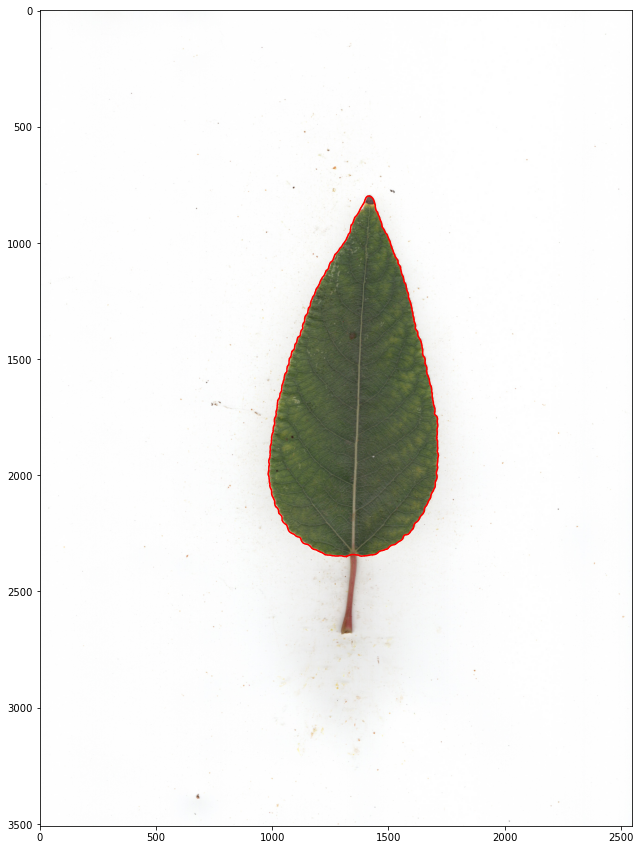


Loading C_1_10_12_bot.jpeg...
Initializing trace...
Iteration completed in 1.33 seconds
Plotting overlay...


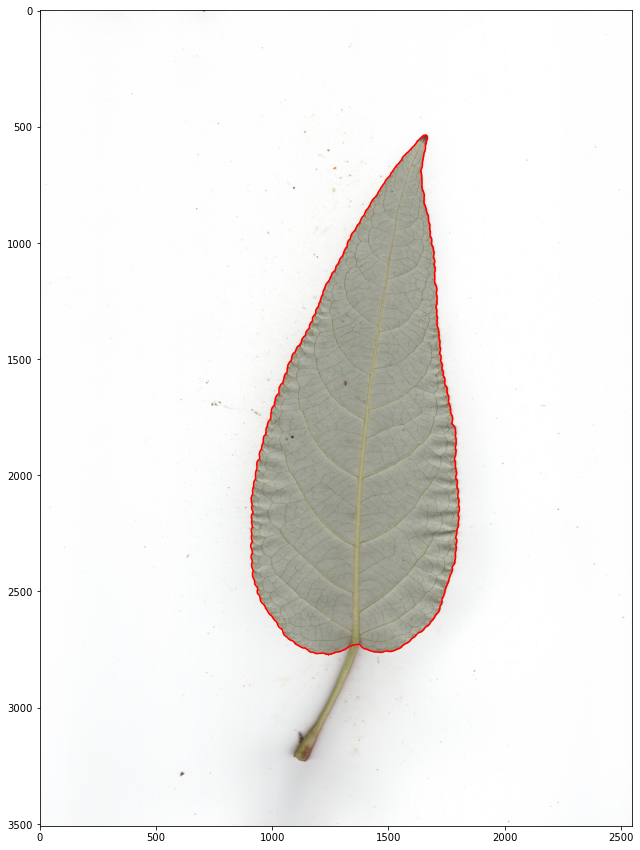


Loading C_1_10_12_top.jpeg...
Initializing trace...
Iteration completed in 1.38 seconds
Plotting overlay...


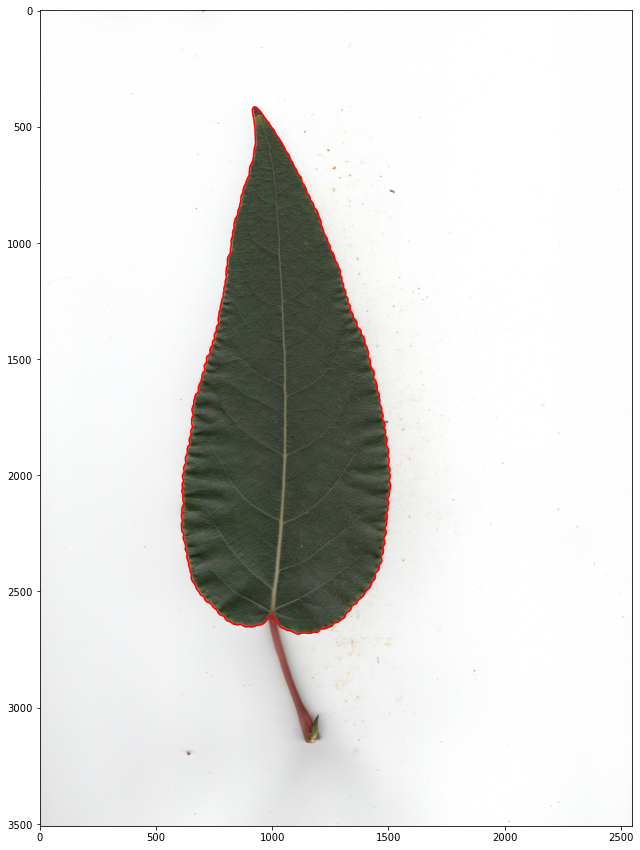


Loading C_1_10_13_bot.jpeg...
Initializing trace...
Iteration completed in 1.13 seconds
Plotting overlay...


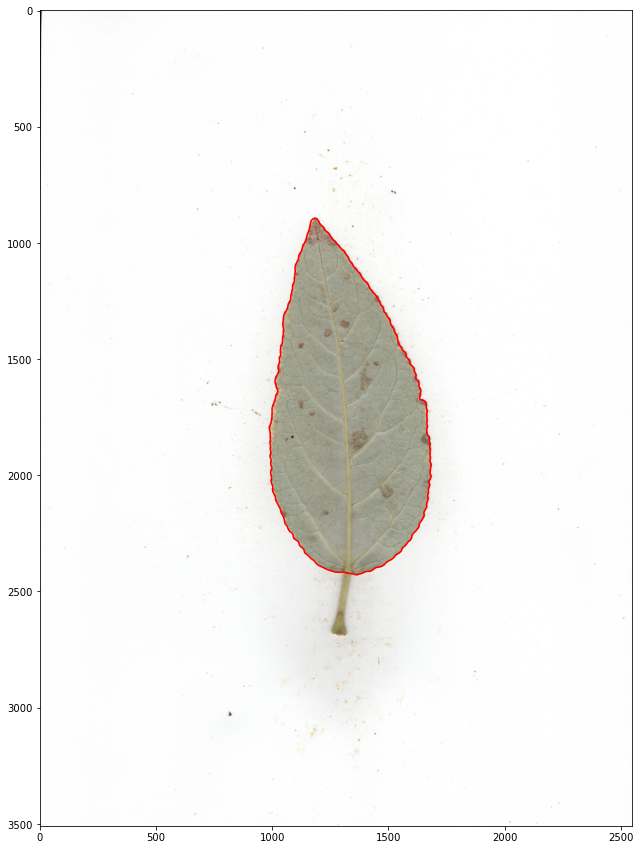


Loading C_1_10_13_top.jpeg...
Initializing trace...
Iteration completed in 1.07 seconds
Plotting overlay...


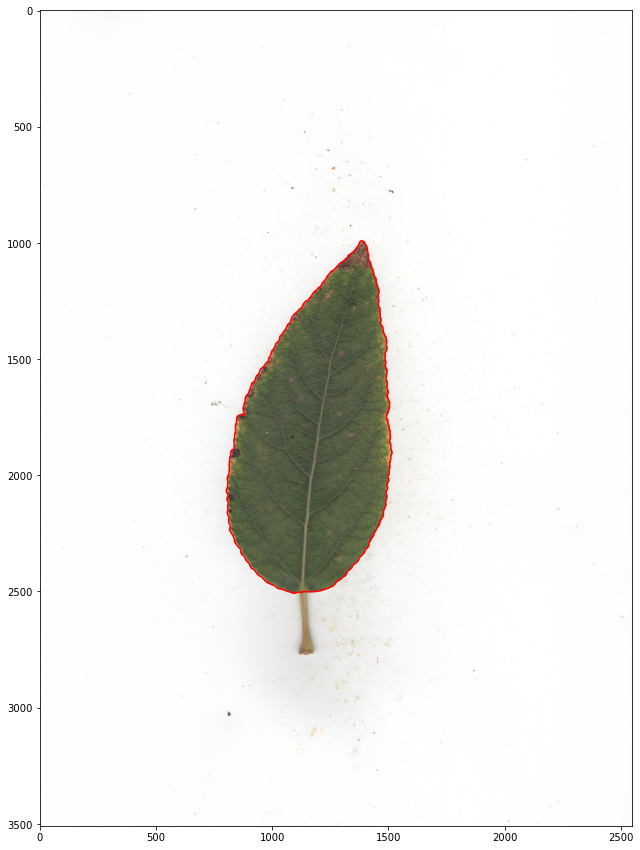


Loading C_1_10_14_bot.jpeg...
Initializing trace...
Iteration completed in 1.06 seconds
Plotting overlay...


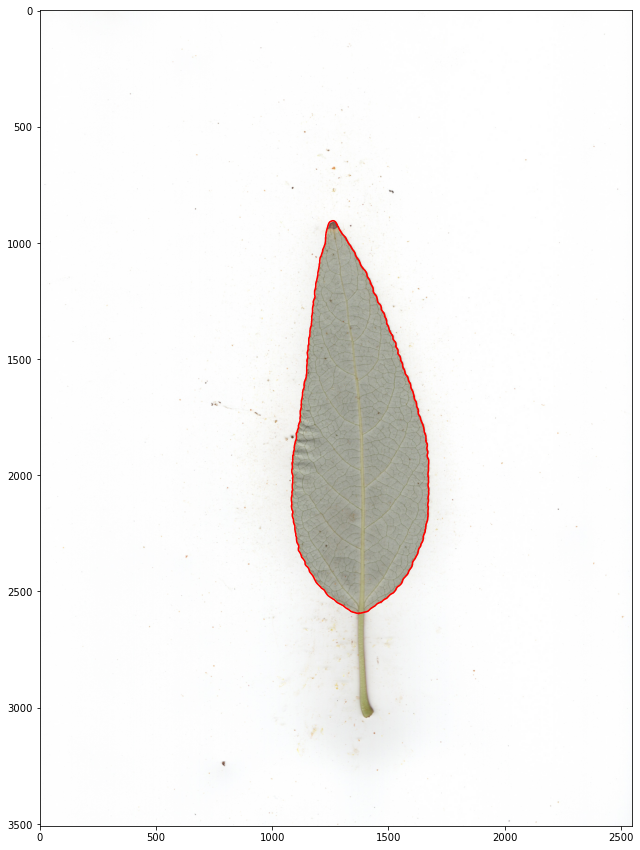


Loading C_1_10_14_top.jpeg...
Initializing trace...
Iteration completed in 1.06 seconds
Plotting overlay...


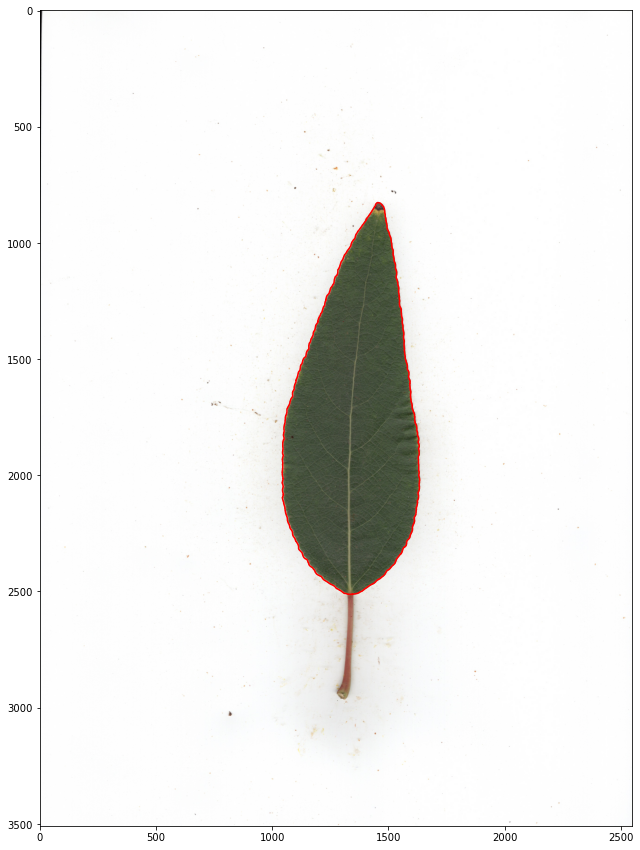


Loading C_1_10_15_bot.jpeg...
Initializing trace...
Iteration completed in 0.99 seconds
Plotting overlay...


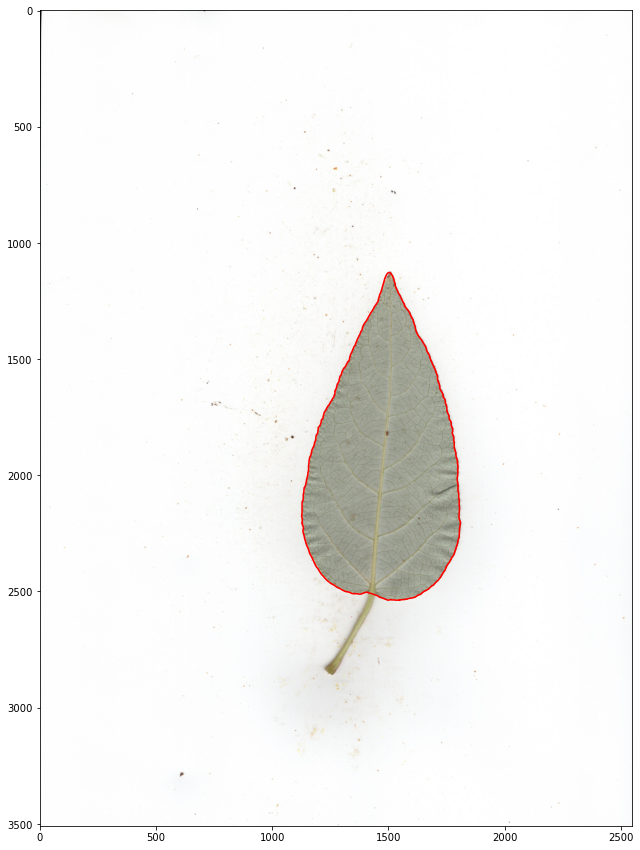


Loading C_1_10_15_top.jpeg...
Initializing trace...
Iteration completed in 1.04 seconds
Plotting overlay...


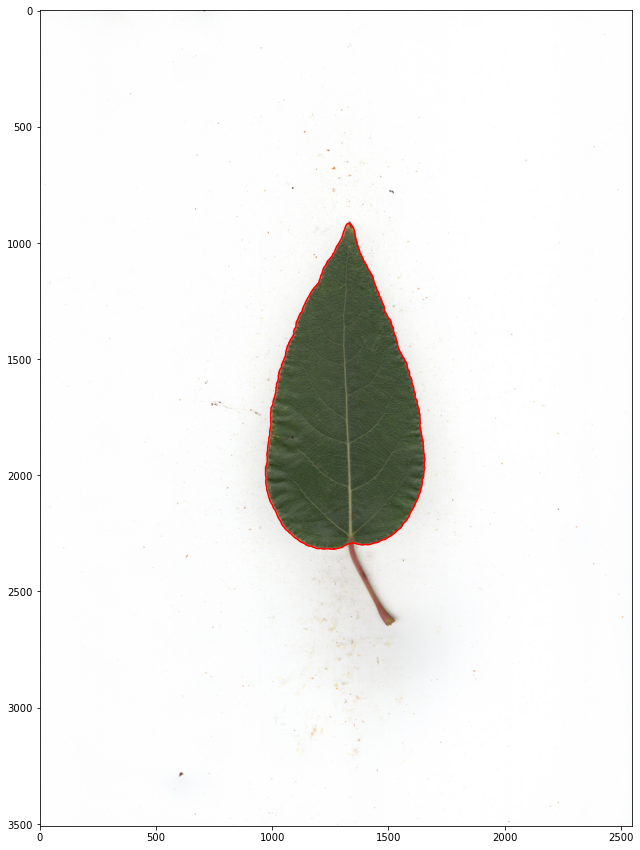

In [3]:
# options
image_path = '../data/images/'
mask_path = '../data/leaf_masks/'
pred_path = '../data/leaf_preds/'
image_extension = 'jpeg'
mask_extension = 'png'
pred_extension = 'png'
max_number = 10 # number of images to trace, set to None for all images
verbose = True
save = False
show = True
fig_size = 15

# get image paths
image_names = [os.path.basename(f) for f in glob.glob(image_path+'*'+image_extension)]
image_names.sort()

# loop over all leaf images
for image_idx, image_name in enumerate(image_names):
    
    # don't exceed maximum
    if max_number is not None:
        if image_idx >= max_number:
            break
            
    # load image
    if verbose:
        print(f'Loading {image_name}...')
    image = TI.load_image(image_path + image_name, pad=True)

    # initialize trace
    if verbose: 
        print('Initializing trace...')
    tile, current_idx = TI.initialize_trace(image)
    
    # trace
    t0 = time.time()
    mask = tracer.trace(image, tile, current_idx)
    t1 = time.time()
    if verbose:
        print('Iteration completed in {0:1.2f} seconds'.format(t1-t0))

    # remove padding
    image = image[
        int(window_size/2):-int(window_size/2), 
        int(window_size/2):-int(window_size/2)]
    mask = mask[
        int(window_size/2):-int(window_size/2), 
        int(window_size/2):-int(window_size/2)]

    # save mask
    if save:
        if verbose: 
            print('Saving mask...')
        save_mask = np.concatenate([mask[:,:,None], mask[:,:,None], mask[:,:,None]], axis=-1)
        pil_mask = Image.fromarray(np.uint8(255*save_mask))
        name = pred_path + image_name.replace(image_extension, pred_extension)
        pil_mask.save(name, quality=100, subsampling=0)

    # plot overlay
    if show:
        if verbose: 
            print('Plotting overlay...')
        contour = measure.find_contours(mask, 0.5)[0] # [N, 2]
        fig = plt.figure(figsize=(image.shape[1]/image.shape[0]*fig_size, fig_size))
        plt.imshow(image)
        plt.plot(contour[:,1], contour[:,0], 'r-')
        plt.show()
        
    if verbose: 
        print()